In [1]:
# ============================================================
# 0. Imports, config, device
# ============================================================
import os
from pathlib import Path
import random

import numpy as np
import librosa
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn import metrics  # voor ROC/AUC

# Reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Data root (same as other notebooks)
DATA_ROOT = Path("../data")

# Audio / feature config
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

# Patch config
PATCH_FRAMES = 64
PATCH_HOP = 32

# Device
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using device:", device, "-", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using device:", device)

PyTorch version: 2.9.1+cu126
Using device: cuda - NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
# ============================================================
# 1. File scanning and audio → log-Mel spectrogram
# ============================================================

def scan_files(data_root=DATA_ROOT, machine_types=None):
    """
    Scan ../data and return a list of dictionaries:
    {
        'path': Path,
        'machine_type': str,
        'split': 'train' or 'test',
        'label': 0 (normal) or 1 (anomaly)
    }
    """
    if machine_types is None:
        machine_types = ["fan", "pump", "slider", "ToyCar", "ToyConveyor", "valve"]

    all_files = []

    for mtype in machine_types:
        for split in ["train", "test"]:
            split_dir = data_root / mtype / split
            if not split_dir.exists():
                continue

            for fname in sorted(split_dir.glob("*.wav")):
                name_lower = fname.name.lower()

                if "normal" in name_lower:
                    label = 0
                elif "anomaly" in name_lower:
                    label = 1
                else:
                    label = None

                all_files.append({
                    "path": fname,
                    "machine_type": mtype,
                    "split": split,
                    "label": label,
                })

    return all_files


file_list = scan_files()
len(file_list), file_list[:5]


(30987,
 [{'path': WindowsPath('../data/fan/train/normal_id_00_00000000.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000001.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000002.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000003.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0},
  {'path': WindowsPath('../data/fan/train/normal_id_00_00000004.wav'),
   'machine_type': 'fan',
   'split': 'train',
   'label': 0}])

In [4]:
def load_audio(path, sr=SAMPLE_RATE):
    """
    Load audio file as mono at a fixed sample rate.

    Returns:
        audio: np.ndarray, shape (samples,)
        sr   : int, sample rate
    """
    audio, sr = librosa.load(path, sr=sr, mono=True)
    return audio, sr


def audio_to_logmelspec(
    audio,
    sr,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
):
    """
    Convert waveform to log-Mel spectrogram.

    Returns:
        log-Mel spectrogram of shape (n_mels, n_frames)
    """
    S = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    logS = np.log(S + 1e-12)
    return logS

In [5]:
def load_audio(path, sr=SAMPLE_RATE):
    """
    Load audio file as mono at a fixed sample rate.

    Returns:
        audio: np.ndarray, shape (samples,)
        sr   : int, sample rate
    """
    audio, sr = librosa.load(path, sr=sr, mono=True)
    return audio, sr


def audio_to_logmelspec(
    audio,
    sr,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
):
    """
    Convert waveform to log-Mel spectrogram.

    Returns:
        log-Mel spectrogram of shape (n_mels, n_frames)
    """
    S = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    logS = np.log(S + 1e-12)
    return logS


In [6]:
# ============================================================
# 2. Spectrogram → patches + collate
# ============================================================

def spec_to_patches(spec, patch_frames=PATCH_FRAMES, patch_hop=PATCH_HOP):
    """
    Convert a spectrogram into overlapping patches.

    spec         : np.array (n_mels, n_frames)
    patch_frames : number of time frames per patch
    patch_hop    : hop size between consecutive patches

    Returns:
        np.array of shape (n_patches, n_mels, patch_frames)
    """
    n_mels, n_frames = spec.shape

    # Pad in time if necessary
    if n_frames < patch_frames:
        pad_width = patch_frames - n_frames
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
        n_frames = spec.shape[1]

    patches = []
    for start in range(0, n_frames - patch_frames + 1, patch_hop):
        end = start + patch_frames
        patch = spec[:, start:end]
        patches.append(patch)

    patches = np.stack(patches, axis=0)
    return patches


def collate_patches_with_meta(batch):
    """
    Custom collate function for DataLoader.

    batch: list of (patch_tensor, meta_dict)

    Returns:
        patches : tensor [B, 1, n_mels, patch_frames]
        metas   : list of metadata dicts
    """
    patches, metas = zip(*batch)
    patches = torch.stack(patches, dim=0)
    return patches, metas

In [7]:
# ============================================================
# 3. Train/val datasets for IDNN (only normal train fan)
# ============================================================

class DCASETrainPatchDataset(Dataset):
    """
    Dataset used to train the Interpolation DNN.

    Uses only normal training files (split == 'train', label == 0).
    For each item:
        - load the audio file
        - compute log-Mel spectrogram
        - extract patches
        - randomly select one patch
        - normalize
        - return (patch_tensor, meta)
    """

    def __init__(
        self,
        file_list,
        machine_type=None,
        val_split=0.2,
        split="train",      # 'train' or 'val'
        normalize=True,
    ):
        # Filter normal train files
        candidates = [
            f for f in file_list
            if f["split"] == "train" and f["label"] == 0
        ]

        if machine_type is not None:
            candidates = [f for f in candidates if f["machine_type"] == machine_type]

        random.shuffle(candidates)
        n_total = len(candidates)
        n_val = int(n_total * val_split)

        val_files = candidates[:n_val]
        train_files = candidates[n_val:]

        if split == "train":
            self.files = train_files
        elif split == "val":
            self.files = val_files
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.normalize = normalize
        self.mean_ = 0.0
        self.std_ = 1.0

        if normalize and split == "train":
            self._fit_normalization(train_files)

    def _fit_normalization(self, files_subset):
        """
        Estimate global mean and std over patches from a subset
        of training files.
        """
        print("Fitting normalization (mean/std) on training subset...")
        values = []

        for f in files_subset:
            audio, sr = load_audio(f["path"])
            spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
            patches = spec_to_patches(spec)
            values.append(patches.reshape(-1))

        values = np.concatenate(values, axis=0)
        self.mean_ = float(values.mean())
        self.std_ = float(values.std() + 1e-6)
        print(f"mean={self.mean_:.4f}, std={self.std_:.4f}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        meta = self.files[idx]
        audio, sr = load_audio(meta["path"])
        spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
        patches = spec_to_patches(spec)

        if patches.shape[0] == 0:
            patch = np.zeros((N_MELS, PATCH_FRAMES), dtype=np.float32)
        else:
            p_idx = np.random.randint(0, patches.shape[0])
            patch = patches[p_idx]

        if self.normalize:
            patch = (patch - self.mean_) / (self.std_ + 1e-8)

        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)  # (1, n_mels, T)
        return patch_tensor, meta

In [8]:
# Instantiate train and val datasets for fan only
train_dataset = DCASETrainPatchDataset(file_list, machine_type="fan", split="train")
val_dataset = DCASETrainPatchDataset(
    file_list,
    machine_type="fan",
    split="val",
    normalize=train_dataset.normalize,
)

# share normalization stats
val_dataset.mean_ = train_dataset.mean_
val_dataset.std_ = train_dataset.std_

# Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_patches_with_meta,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_patches_with_meta,
)

Fitting normalization (mean/std) on training subset...
mean=-6.9173, std=2.0605


In [9]:
# ============================================================
# 4. Helpers: patches → sequence, center index
# ============================================================

def patches_to_sequence(patches):
    """
    Convert patches from [B, 1, n_mels, T] to [B, T, n_mels].
    """
    if patches.dim() == 4:
        B, C, F, T = patches.shape
        assert C == 1
        x = patches.squeeze(1)       # (B, n_mels, T)
        x = x.permute(0, 2, 1)       # (B, T, n_mels)
        return x
    elif patches.dim() == 3:
        x = patches.permute(0, 2, 1) # (B, T, n_mels)
        return x
    else:
        raise ValueError(f"Unexpected shape: {patches.shape}")


def get_center_index(num_frames):
    """
    Return center time index for T frames: floor(T/2)
    """
    return num_frames // 2


In [10]:
# ============================================================
# 5. Interpolation DNN model
# ============================================================

class InterpolationDNN(nn.Module):
    """
    Simple MLP that predicts the center frame of a patch
    given all other frames (context).

    Input:  patches [B, 1, n_mels, T]
    Output: center_frame_pred [B, n_mels]
    """

    def __init__(self, n_mels=N_MELS, patch_frames=PATCH_FRAMES, hidden_dim=1024):
        super().__init__()
        self.n_mels = n_mels
        self.patch_frames = patch_frames

        # context frames = all frames except center
        context_frames = patch_frames - 1
        in_dim = n_mels * context_frames
        out_dim = n_mels

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, patches):
        # patches: [B, 1, n_mels, T]
        x_seq = patches_to_sequence(patches)       # [B, T, n_mels]
        B, T, F = x_seq.shape
        center_idx = get_center_index(T)

        # Target center frame
        target_center = x_seq[:, center_idx, :]    # [B, F]

        # Context = all frames except center
        left = x_seq[:, :center_idx, :]           # [B, center, F]
        right = x_seq[:, center_idx+1:, :]        # [B, T-center-1, F]
        context = torch.cat([left, right], dim=1) # [B, T-1, F]

        context_flat = context.reshape(B, -1)     # [B, (T-1)*F]
        pred_center = self.mlp(context_flat)      # [B, F]

        return pred_center, target_center


In [11]:
# ============================================================
# 5. Interpolation DNN model
# ============================================================

class InterpolationDNN(nn.Module):
    """
    Simple MLP that predicts the center frame of a patch
    given all other frames (context).

    Input:  patches [B, 1, n_mels, T]
    Output: center_frame_pred [B, n_mels]
    """

    def __init__(self, n_mels=N_MELS, patch_frames=PATCH_FRAMES, hidden_dim=1024):
        super().__init__()
        self.n_mels = n_mels
        self.patch_frames = patch_frames

        # context frames = all frames except center
        context_frames = patch_frames - 1
        in_dim = n_mels * context_frames
        out_dim = n_mels

        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, patches):
        # patches: [B, 1, n_mels, T]
        x_seq = patches_to_sequence(patches)       # [B, T, n_mels]
        B, T, F = x_seq.shape
        center_idx = get_center_index(T)

        # Target center frame
        target_center = x_seq[:, center_idx, :]    # [B, F]

        # Context = all frames except center
        left = x_seq[:, :center_idx, :]           # [B, center, F]
        right = x_seq[:, center_idx+1:, :]        # [B, T-center-1, F]
        context = torch.cat([left, right], dim=1) # [B, T-1, F]

        context_flat = context.reshape(B, -1)     # [B, (T-1)*F]
        pred_center = self.mlp(context_flat)      # [B, F]

        return pred_center, target_center


In [12]:
# Instantiate model, optimizer, loss
idnn_model = InterpolationDNN(
    n_mels=N_MELS,
    patch_frames=PATCH_FRAMES,
    hidden_dim=1024,
).to(device)

optimizer = torch.optim.Adam(idnn_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # mean squared error for center-frame

In [13]:
# ============================================================
# 6. Training and validation loops
# ============================================================

def train_idnn_epoch(model, loader, optimizer, device, max_batches=None):
    model.train()
    total_loss = 0.0
    n_batches = 0

    for batch_idx, (patch_batch, meta_batch) in enumerate(loader):
        if (max_batches is not None) and (batch_idx >= max_batches):
            break

        patch_batch = patch_batch.to(device)  # [B,1,n_mels,T]

        optimizer.zero_grad()
        pred_center, target_center = model(patch_batch)
        loss = criterion(pred_center, target_center)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    if n_batches == 0:
        return 0.0
    return total_loss / n_batches


@torch.no_grad()
def eval_idnn_epoch(model, loader, device, max_batches=None):
    model.eval()
    total_loss = 0.0
    n_batches = 0

    for batch_idx, (patch_batch, meta_batch) in enumerate(loader):
        if (max_batches is not None) and (batch_idx >= max_batches):
            break

        patch_batch = patch_batch.to(device)
        pred_center, target_center = model(patch_batch)
        loss = criterion(pred_center, target_center)

        total_loss += loss.item()
        n_batches += 1

    if n_batches == 0:
        return 0.0
    return total_loss / n_batches


In [14]:
# ============================================================
# 7. Train IDNN
# ============================================================

NUM_EPOCHS = 30

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_idnn_epoch(idnn_model, train_loader, optimizer, device)
    val_loss = eval_idnn_epoch(idnn_model, val_loader, device)

    print(f"[Epoch {epoch:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

[Epoch 01] train_loss=0.2871 | val_loss=0.1532
[Epoch 02] train_loss=0.1431 | val_loss=0.1380
[Epoch 03] train_loss=0.1375 | val_loss=0.1341
[Epoch 04] train_loss=0.1343 | val_loss=0.1381
[Epoch 05] train_loss=0.1336 | val_loss=0.1305
[Epoch 06] train_loss=0.1316 | val_loss=0.1303
[Epoch 07] train_loss=0.1304 | val_loss=0.1304
[Epoch 08] train_loss=0.1301 | val_loss=0.1259
[Epoch 09] train_loss=0.1278 | val_loss=0.1282
[Epoch 10] train_loss=0.1268 | val_loss=0.1263
[Epoch 11] train_loss=0.1259 | val_loss=0.1272
[Epoch 12] train_loss=0.1256 | val_loss=0.1228
[Epoch 13] train_loss=0.1254 | val_loss=0.1241
[Epoch 14] train_loss=0.1252 | val_loss=0.1308
[Epoch 15] train_loss=0.1248 | val_loss=0.1274
[Epoch 16] train_loss=0.1242 | val_loss=0.1252
[Epoch 17] train_loss=0.1243 | val_loss=0.1231
[Epoch 18] train_loss=0.1234 | val_loss=0.1243
[Epoch 19] train_loss=0.1235 | val_loss=0.1244
[Epoch 20] train_loss=0.1214 | val_loss=0.1229
[Epoch 21] train_loss=0.1212 | val_loss=0.1238
[Epoch 22] tr

Train errors: mean = 0.11874164140396783 std = 0.02442112298865792
Val   errors: mean = 0.11991664947701149 std = 0.023593755435066695


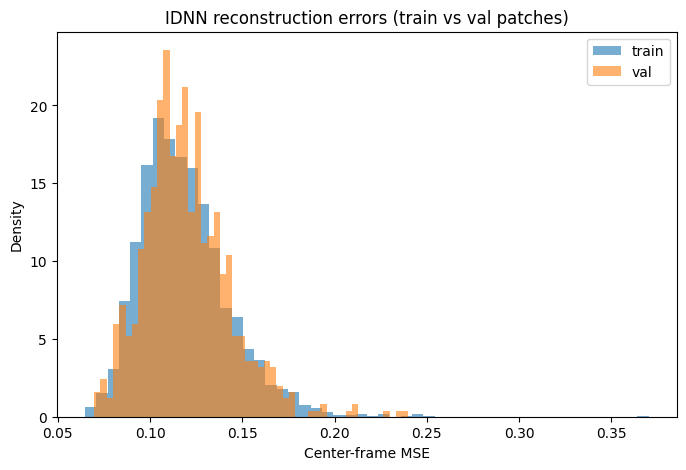

In [15]:
# ============================================================
# 8. Analyse train vs val reconstruction error distribution
# ============================================================

@torch.no_grad()
def compute_center_errors_idnn(model, loader, device):
    model.eval()
    all_errors = []

    for patch_batch, meta_batch in loader:
        patch_batch = patch_batch.to(device)
        pred_center, target_center = model(patch_batch)
        per_sample = F.mse_loss(pred_center, target_center, reduction="none")  # [B, n_mels]
        per_sample = per_sample.mean(dim=1)  # [B]
        all_errors.extend(per_sample.cpu().numpy().tolist())

    return np.array(all_errors)


train_errors = compute_center_errors_idnn(idnn_model, train_loader, device)
val_errors   = compute_center_errors_idnn(idnn_model, val_loader, device)

print("Train errors: mean =", train_errors.mean(), "std =", train_errors.std())
print("Val   errors: mean =", val_errors.mean(),   "std =", val_errors.std())

plt.figure(figsize=(8,5))
plt.hist(train_errors, bins=50, alpha=0.6, label="train", density=True)
plt.hist(val_errors,   bins=50, alpha=0.6, label="val",   density=True)
plt.xlabel("Center-frame MSE")
plt.ylabel("Density")
plt.legend()
plt.title("IDNN reconstruction errors (train vs val patches)")
plt.show()


In [16]:
# ============================================================
# 9. Test dataset (fan test, normal + anomaly) for evaluation
# ============================================================

class DCASETestPatchDataset(Dataset):
    """
    Dataset for evaluating IDNN on test data.

    Each item:
        - one random patch from a test file (normal or anomaly)
        - metadata (including label)
    """

    def __init__(
        self,
        file_list,
        machine_type=None,
        normalize=True,
        mean_=0.0,
        std_=1.0,
    ):
        self.files = [
            f for f in file_list
            if f["split"] == "test" and f["label"] is not None
        ]

        if machine_type is not None:
            self.files = [f for f in self.files if f["machine_type"] == machine_type]

        self.normalize = normalize
        self.mean_ = mean_
        self.std_ = std_

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        info = self.files[idx]
        audio, sr = load_audio(info["path"])
        spec = audio_to_logmelspec(audio, sr, n_mels=N_MELS)
        patches = spec_to_patches(spec)

        if patches.shape[0] == 0:
            patch = np.zeros((N_MELS, PATCH_FRAMES), dtype=np.float32)
        else:
            i = np.random.randint(0, patches.shape[0])
            patch = patches[i]

        if self.normalize:
            patch = (patch - self.mean_) / (self.std_ + 1e-8)

        patch_tensor = torch.from_numpy(patch).float().unsqueeze(0)  # (1, n_mels, T)

        meta = {
            "path": str(info["path"]),
            "label": int(info["label"]),
            "machine_type": info["machine_type"],
            "split": info["split"],
        }

        return patch_tensor, meta


test_dataset = DCASETestPatchDataset(
    file_list,
    machine_type="fan",
    normalize=True,
    mean_=train_dataset.mean_,
    std_=train_dataset.std_,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_patches_with_meta,
)
len(test_dataset)


1875

In [17]:
# ============================================================
# 10. Patch-wise errors on test set and per-recording scores
# ============================================================

from collections import defaultdict

@torch.no_grad()
def compute_idnn_patch_errors_test(model, loader, device):
    model.eval()
    results = []

    for patch_batch, meta_batch in loader:
        patch_batch = patch_batch.to(device)
        pred_center, target_center = model(patch_batch)
        per_sample = F.mse_loss(pred_center, target_center, reduction="none").mean(dim=1)
        per_sample = per_sample.cpu().numpy()

        for err, meta in zip(per_sample, meta_batch):
            results.append({
                "path": meta["path"],
                "label": meta["label"],
                "error": float(err),
            })

    return results


test_patch_results = compute_idnn_patch_errors_test(idnn_model, test_loader, device)
len(test_patch_results), test_patch_results[:3]


(1875,
 [{'path': '..\\data\\fan\\test\\anomaly_id_00_00000000.wav',
   'label': 1,
   'error': 0.09172454476356506},
  {'path': '..\\data\\fan\\test\\anomaly_id_00_00000001.wav',
   'label': 1,
   'error': 0.12159202247858047},
  {'path': '..\\data\\fan\\test\\anomaly_id_00_00000002.wav',
   'label': 1,
   'error': 0.13114559650421143}])

Normal recordings: N = 400 mean = 0.1254102214425802 std = 0.025915509425603733
Anomaly recordings: N = 1475 mean = 0.12938444780091107 std = 0.02820472590258574


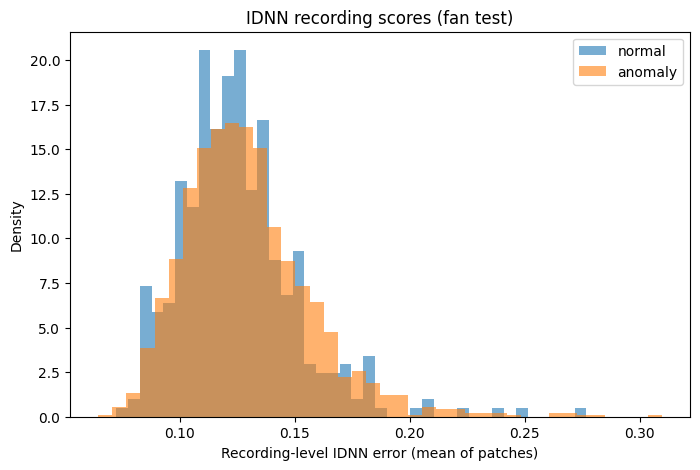

In [18]:
def aggregate_per_recording(patch_results, method="mean"):
    """
    Aggregate patch-level errors into one score per recording.
    """
    per_file_errors = defaultdict(list)
    per_file_labels = {}

    for item in patch_results:
        p = item["path"]
        per_file_errors[p].append(item["error"])
        per_file_labels[p] = int(item["label"])

    recording_scores = {}
    for p, errs in per_file_errors.items():
        errs = np.array(errs, dtype=np.float32)
        if method == "mean":
            score = float(errs.mean())
        elif method == "max":
            score = float(errs.max())
        else:
            raise ValueError("Unknown method")
        recording_scores[p] = {
            "score": score,
            "label": per_file_labels[p],
        }

    return recording_scores


test_recording_scores = aggregate_per_recording(test_patch_results, method="mean")

scores_normal = [v["score"] for v in test_recording_scores.values() if v["label"] == 0]
scores_anom   = [v["score"] for v in test_recording_scores.values() if v["label"] == 1]

print("Normal recordings: N =", len(scores_normal),
      "mean =", np.mean(scores_normal), "std =", np.std(scores_normal))
print("Anomaly recordings: N =", len(scores_anom),
      "mean =", np.mean(scores_anom), "std =", np.std(scores_anom))

plt.figure(figsize=(8,5))
plt.hist(scores_normal, bins=40, alpha=0.6, label="normal",  density=True)
plt.hist(scores_anom,   bins=40, alpha=0.6, label="anomaly", density=True)
plt.xlabel("Recording-level IDNN error (mean of patches)")
plt.ylabel("Density")
plt.legend()
plt.title("IDNN recording scores (fan test)")
plt.show()


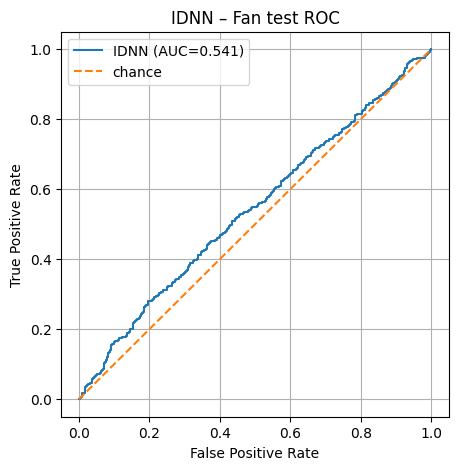

AUC (IDNN, per recording): 0.5412135593220339


In [19]:
# ============================================================
# 11. ROC / AUC for IDNN on fan test set
# ============================================================

y_true = []
y_score = []

for p, info in test_recording_scores.items():
    y_true.append(info["label"])
    y_score.append(info["score"])

y_true = np.array(y_true, dtype=np.int64)
y_score = np.array(y_score, dtype=np.float32)

fpr, tpr, thr = metrics.roc_curve(y_true, y_score, pos_label=1)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"IDNN (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"--", label="chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("IDNN – Fan test ROC")
plt.legend()
plt.grid(True)
plt.show()

print("AUC (IDNN, per recording):", auc)
